In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import Lasso, LassoCV

In [2]:
# filtering out warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# getting all the downloaded datasets
house_price_index = pd.read_csv('house_index.csv')
gdp = pd.read_csv('gdp.csv')
inflation_rates = pd.read_csv('inflation_rates.csv', skiprows=3)
mortgage_rates = pd.read_csv('mortgage_rates.csv')
unemployment = pd.read_csv('unemployment_rate.csv')
consumer_sentiment = pd.read_csv('consumer_sentiment.csv')

In [4]:
# correcting date format and standardising column names
dataframes = [gdp, house_price_index, mortgage_rates, consumer_sentiment, unemployment]
column_mappings = [
    {'DATE': 'date', 'GDP': 'gdp'},
    {'DATE': 'date', 'CSUSHPISA': 'price_index'},
    {'DATE': 'date', 'MORTGAGE30US': 'mortgage_rate'},
    {'DATE': 'date', 'UMCSENT': 'consumer_sentiment'},
    {'DATE': 'date', 'UNRATE': 'unemployment_rate'}]
for df, mapping in zip(dataframes, column_mappings):
    df.rename(columns=mapping, inplace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [5]:
# filtering house price index
house_price_index = house_price_index[(house_price_index['date'] > '2002-04-01') & (house_price_index['date'] <= '2022-01-01')]
house_price_index.head()

,date,price_index
2,2002-07-01,123.8326666666666633
3,2002-10-01,126.6763333333333333
4,2003-01-01,129.3213333333333333
5,2003-04-01,131.7560000000000000
6,2003-07-01,135.0133333333333333


In [6]:
# inflation rates data is in different format
inflation_rates.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5.370290,5.245878,6.571396,6.399343,4.720811,4.653665,7.321106,6.824727,10.526577,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,1.768436,2.130817,1.487416,1.764635,1.784050,1.760112,2.437609,3.653533,7.967574,NaN
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,7.280387,9.353840,30.698958,29.842578,19.630594,17.079704,22.271564,25.754266,NaN,NaN


In [7]:
# formatting inflation rates data for analysis
inflation_rates = inflation_rates[inflation_rates['Country Name'] == 'United States']
inflation_rates = pd.melt(inflation_rates, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='date', value_name='inflation_rate')
inflation_rates.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
inflation_rates['date'] = pd.to_datetime(inflation_rates['date'], errors='coerce')
inflation_rates.reset_index(drop=True, inplace=True)
inflation_rates.head()

,date,inflation_rate
0,1960-01-01,1.457976
1,1961-01-01,1.070724
2,1962-01-01,1.198773
3,1963-01-01,1.239669
4,1964-01-01,1.278912


In [8]:
# interpolating quarterly data for inflation rate
dates = []
for i in range(2002, 2023):
    for j in [1, 4, 7, 10]:
        date = f'{i}-{j}-01'
        dates.append(date)
dates = pd.to_datetime(dates)
quarterly_df = pd.DataFrame({'date': dates})
inflation_rates = pd.merge(quarterly_df, inflation_rates, on='date', how='left')
inflation_rates['inflation_rate'] = inflation_rates['inflation_rate'].interpolate()
inflation_rates.head()

,date,inflation_rate
0,2002-01-01,1.586032
1,2002-04-01,1.757047
2,2002-07-01,1.928063
3,2002-10-01,2.099079
4,2003-01-01,2.270095


In [9]:
# merging all variables in one dataframe
df = pd.merge(gdp, inflation_rates, on='date', how='inner')
df = pd.merge(df, mortgage_rates, on='date', how='inner')
df = pd.merge(df, consumer_sentiment, on='date', how='inner')
df = pd.merge(df, unemployment, on='date', how='inner')
df = pd.merge(df, house_price_index, on='date', how='inner')
df.set_index('date', inplace = True)
df.head()

,gdp,inflation_rate,mortgage_rate,consumer_sentiment,unemployment_rate,price_index
date,,,,,,
2002-10-01,11061.433,2.099079,6.075385,83.8333333333333333,5.866667,126.6763333333333333
2003-01-01,11174.129,2.270095,5.840769,79.9666666666666667,5.866667,129.3213333333333333
2003-04-01,11312.766,2.371880,5.506923,89.2666666666666667,6.133333,131.7560000000000000
2003-07-01,11566.669,2.473666,6.033846,89.3000000000000000,6.133333,135.0133333333333333
2003-10-01,11772.234,2.575451,5.919286,91.9666666666666667,5.833333,138.8346666666666600


In [10]:
# checking datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78 entries, 2002-10-01 to 2022-01-01
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gdp                 78 non-null     float64
 1   inflation_rate      78 non-null     float64
 2   mortgage_rate       78 non-null     float64
 3   consumer_sentiment  78 non-null     object 
 4   unemployment_rate   78 non-null     float64
 5   price_index         78 non-null     object 
dtypes: float64(4), object(2)
memory usage: 4.3+ KB


In [11]:
# correcting datatype
df[['consumer_sentiment', 'price_index']] = df[['consumer_sentiment', 'price_index']].apply(pd.to_numeric, errors='coerce')

In [12]:
# checking statistics of data
df.describe()

,gdp,inflation_rate,mortgage_rate,consumer_sentiment,unemployment_rate,price_index
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,16844.699385,2.370632,4.657542,83.340598,6.103419,175.339355
std,3516.488824,1.421590,1.100820,11.446533,1.996119,34.707106
min,11061.433000,-0.355546,2.760714,57.666667,3.600000,126.676333
25%,14409.287000,1.553365,3.820000,74.816667,4.641667,148.026083
50%,16263.328000,2.239162,4.405000,83.933333,5.483333,170.115167
75%,19399.003250,3.017674,5.767308,93.266667,7.458333,189.055750
max,25029.116000,8.002800,6.602308,98.933333,12.966667,291.121333


In [13]:
# scaling the data
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index = df.index)
scaled_df.head()

,gdp,inflation_rate,mortgage_rate,consumer_sentiment,unemployment_rate,price_index
date,,,,,,
2002-10-01,-1.655259,-0.192257,1.296324,0.043325,-0.119374,-1.411181
2003-01-01,-1.623003,-0.071179,1.081817,-0.296664,-0.119374,-1.334478
2003-04-01,-1.583323,0.000884,0.776584,0.521068,0.015083,-1.263875
2003-07-01,-1.510653,0.072947,1.258346,0.523999,0.015083,-1.169416
2003-10-01,-1.451817,0.145010,1.153604,0.758474,-0.136181,-1.058601


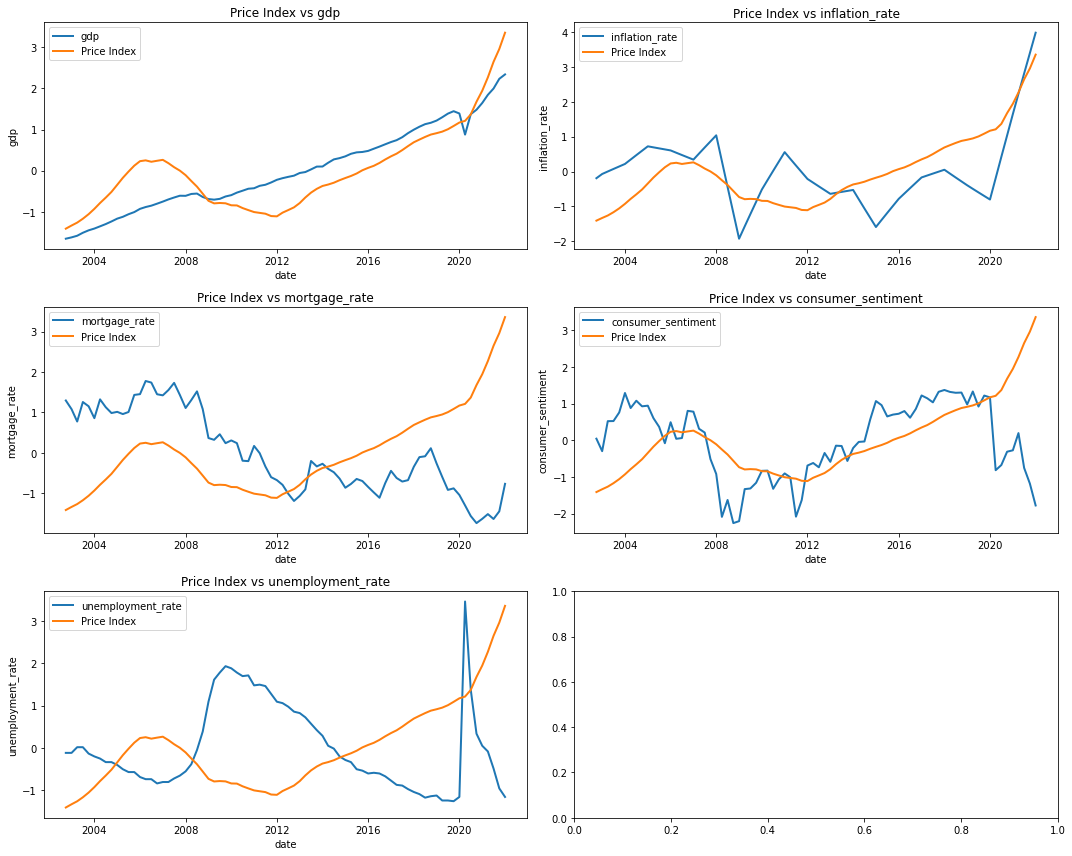

In [14]:
# visualising the price index against all other variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()
for i, column in enumerate(scaled_df.columns.drop('price_index')):
    sns.lineplot(data=scaled_df, x=scaled_df.index, y=column, linewidth=2, label = column, ax=axes[i])
    sns.lineplot(data=scaled_df, x=scaled_df.index, y='price_index', linewidth=2, label = 'Price Index', ax=axes[i])
    axes[i].set_title(f"Price Index vs {column}")
    
plt.tight_layout()
plt.show()

<AxesSubplot:>

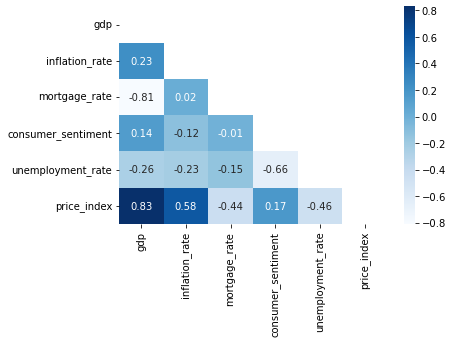

In [15]:
# checking correlations
corr = round(scaled_df.corr(), 2)

sns.heatmap(corr, mask = np.triu(np.ones_like(corr)), cmap="Blues", annot=True)

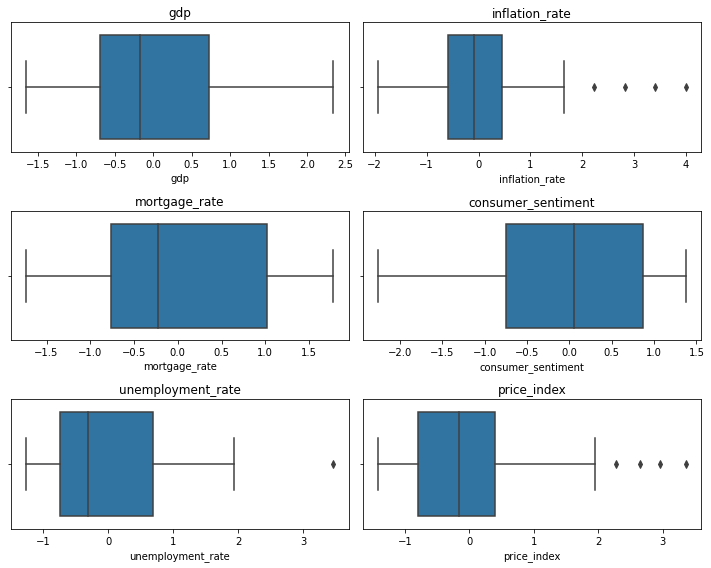

In [16]:
# boxplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = axes.flatten()
for i, column in enumerate(scaled_df.columns):
    sns.boxplot(data=scaled_df, x=column, ax=axes[i])
    axes[i].set_title(column)
    
plt.tight_layout()
plt.show()

In [17]:
# separating data in predictors and prediction
X = scaled_df.drop('price_index', axis = 1)
y = scaled_df.price_index

In [18]:
# splitting data for training and validaition
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 1)

In [19]:
# defining function for rmse
def rmse(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

In [20]:
# Linear model (using LassoCV)
lasso_model = LassoCV(alphas = np.arange(0.01, 25, 0.25), cv = 5, max_iter = 50000)
lasso_model.fit(X_train, y_train)

# training best model
lr_best = Lasso(alpha = lasso_model.alpha_)
lr_best.fit(X_train, y_train)

Lasso(alpha=0.01)

In [21]:
# vewinng the accuracy of the model
train_rmse = rmse(y_train, lr_best.predict(X_train))
val_rmse = rmse(y_val, lr_best.predict(X_val))

train_r2 = r2_score(y_train, lr_best.predict(X_train))
val_r2 = r2_score(y_val, lr_best.predict(X_val))

In [22]:
pd.DataFrame([[train_rmse, val_rmse], [train_r2, val_r2]], columns=['Train', 'Validation'], 
              index = ['RMSE', 'R2'])

,Train,Validation
RMSE,0.284800,0.356782
R2,0.913096,0.889303


In [23]:
# checking influence of different features on the prediction
feat_coef = pd.DataFrame({'coefficients': lr_best.coef_.flatten(), 'features': scaled_df.columns.drop('price_index')})
feat_coef.sort_values(by = 'coefficients', ascending = False)

,coefficients,features
0,1.017968,gdp
2,0.344418,mortgage_rate
1,0.335290,inflation_rate
3,0.039278,consumer_sentiment
4,0.000000,unemployment_rate


In [25]:
feat_coef.to_excel('output_file.xlsx', index=True)